# Full code pipeline for running an ensemble on the provided ECG data with PySpark and Torch
Note: You need to run the Docker Image to get the appropraite dependencies correct to run this notebook yourself. See our [docker.md](docker.md) for instructions.

## Start spark session
This will be used by `TorchDistributor` to allocate the necessary memory space for each process.

In [1]:
from pyspark.ml.torch.distributor import TorchDistributor 
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

## Install torch
This is the only package we need that isn't part of the Docker Image that you need to use to run this code.

In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


## Import libraries and create directory for models
Most important package is torch, some of the packages are only used for visualizations or to manage the data.

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, DataLoader
from scipy import stats
import time as time
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import warnings
from datetime import datetime

# We create a new directory called 'models_and_results/CURRENT_DATE_TIME' where we store 
# the models and the corresponding anomaly scores
warnings.filterwarnings("ignore", category=FutureWarning)
current_time = datetime.now().strftime('%d%m_%H%M%S')
base_directory = './models_and_results/'
new_directory = os.path.join(base_directory, current_time)
os.makedirs(new_directory, exist_ok=True)

## Import the dataset

The dataset has been taken from [this link](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). It comprises 4998 stime series, each evaluated in 140 time points. An additional column is added for labels (1: normal, 0: anomalous) There are 2079 normal signals in total (41.6% of the total dataset).
* `input_dim`: number of time points for each time series
* `encoding_dim`: number of encoded features in the latent space

The following code imports and prepares the dataset for training and testing

In [4]:
# For reproducibility we set a seed. 
random_SEED = 42
np.random.seed(random_SEED) 

# Load data
df_raw_data = pd.read_csv('ECG5000/ecg.csv', header=None) 
# Set name for columns
df_raw_data.columns = [f't{i+1}' for i in range(df_raw_data.shape[1] - 1)] + ['label'] 
# Transform to tensor (last column is for label)
torch_data_normal = torch.tensor(df_raw_data[df_raw_data['label'] == True].values[:,:-1], dtype=torch.float32) 
# Transform to tensor (last column is for label)
torch_data_anomalous = torch.tensor(df_raw_data[df_raw_data['label'] == False].values[:,:-1], dtype=torch.float32) 

# We hold out some normal data that later is used for testing, 
# the rest of the normal data we store in torch_data_normal
hold_out_idx = torch.tensor(random.sample(range(torch_data_normal.shape[0]), 500)) 
all_indices = torch.arange(torch_data_normal.shape[0]) 
remaining_indices = all_indices[~torch.isin(all_indices, hold_out_idx)]
hold_out_normal = torch_data_normal[hold_out_idx,:]
torch_data_normal = torch_data_normal[remaining_indices,:]

# The following variables are used when defining our Autoencoder model
input_dim = torch_data_normal.shape[1]
encoding_dim = 10

## Print some numbers of the data
print(f'Training data (normal): {torch_data_normal.shape[0]}')
print(f'Anomalous data: {torch_data_anomalous.shape[0]}')
print(f'Hold-out data (normal): {hold_out_normal.shape[0]}')
print(f'Total data: {hold_out_normal.shape[0]+torch_data_anomalous.shape[0]+torch_data_normal.shape[0]}')

Training data (normal): 2419
Anomalous data: 2079
Hold-out data (normal): 500
Total data: 4998


## Split the dataset inot `num_splits` chunks
* `num_splits`:  number of chunks to partition the dataset into
* This will also be the same number of nodes (CPU cores) we distribute to

In [5]:
train_datasets = []

# Chose arbitrary number of splits (less than 10 for data of this size)
num_splits = 9
# Make as even splits as possible
split_sizes = [torch_data_normal.shape[0] // num_splits] * (num_splits - 1) + [torch_data_normal.shape[0] - (torch_data_normal.shape[0] // num_splits) * (num_splits - 1)]
train_datasets = torch.split(torch_data_normal, split_sizes)
for tt_idx, tt in enumerate(train_datasets):
    print(f"{tt.shape[0]} data in chunk number {tt_idx+1}")

268 data in chunk number 1
268 data in chunk number 2
268 data in chunk number 3
268 data in chunk number 4
268 data in chunk number 5
268 data in chunk number 6
268 data in chunk number 7
268 data in chunk number 8
275 data in chunk number 9


## Define the model 
The same model will be used by each process, by this could be generalized 
Here we define an Autoencoder with an encoder three linear layers and ReLU activation between the the layers. The Decoder consists of a mirrored architecture.

In [6]:
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(TimeSeriesAutoencoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded
    
# We create a list containing the models
models = [] 
# We initialize a model for each node (CPU core) 
for i in range(num_splits): 
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))

## Define functions to distribute

In [7]:
def train_data_loader(split_index, datasets, batch_size):
    """
    This function creates the dataloader for each node.

    Parameters
    ----------
    split_index : (int)
        The number of the assigned node (0,1,...)
    datasets : (list)
        A list of datasets
    batch_size : (int)
        Size of the minibatch

    Returns
    -------
    A dataloader for the dataset at index split_index
    """

    train_dataset_split_index = TensorDataset(datasets[split_index]) 
    train_dataloader_split_index = DataLoader(train_dataset_split_index, batch_size=batch_size, shuffle=True)
    
    return(train_dataloader_split_index)

def training(models, train_datasets, criterion, num_epochs, batch_size, learning_rate, print_epoch):
    """
    This function is used by the TorchDistributor.

    Parameters
    ----------
    models : [models]
        A list of models to be trained
    train_datasets : (list)
        A list of datasets to be used for training
    criterion : (function)
        Loss function
    num_epochs : (int)
        Number of epochs to be run
    batch_size : (int)
        Size of the minibatch
    learning_rate : (float)
        The learning rate for the optimizer
    print_epoch : (int)
        Determines if we print a loss and how often, set to 0 to omit print
    """
    # local rank of this process (used to access the corresponding model)
    local_rank = int(os.environ["LOCAL_RANK"]) 

    # access the model
    model = models[local_rank] 

    # load the data for this process
    dataloader = train_data_loader(local_rank, train_datasets, batch_size) 
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(1,num_epochs+1): 
        total_loss = 0
        for batch in dataloader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if print_epoch != 0:
            if epoch % print_epoch == 0:
                print(f"Model {local_rank} Epoch [{epoch}/{num_epochs}], Loss: {total_loss/len(dataloader):.6f}")

    ## kommentera
    torch.save(model.state_dict(), new_directory + os.sep + "ensemble_" + str(local_rank) + ".pth") # save this model

    return 
    

## Run the training function with TorchDistributor
### Refer to the report.md

In [8]:
criterion = nn.MSELoss()

# Hyperparameters
num_epochs = 100
batch_size = 32
learning_rate = 0.01

# print the loss function's value every 20 epochs
print_epoch = 100

# Benchmark the training
start_time = time.time()

# run takes arguments: (<function to be run>, <arguments to be passed to function>)
TorchDistributor(num_processes=num_splits, local_mode=True, use_gpu=False).run(training, # function to run
                models, 
                train_datasets, 
                criterion, 
                num_epochs, 
                batch_size, learning_rate, print_epoch) # arguments to pass to function

print('It took ' , time.time()-start_time ,'s')

INFO:TorchDistributor:Started local training with 9 processes
INFO:TorchDistributor:Finished local training with 9 processes


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
*****************************************
Model 6 Epoch [100/100], Loss: 0.024010
Model 8 Epoch [100/100], Loss: 0.042174
Model 5 Epoch [100/100], Loss: 0.029528
Model 0 Epoch [100/100], Loss: 0.029586
Model 4 Epoch [100/100], Loss: 0.027171
Model 3 Epoch [100/100], Loss: 0.025326
Model 2 Epoch [100/100], Loss: 0.024000
Model 1 Epoch [100/100], Loss: 0.024716
Model 7 Epoch [100/100], Loss: 0.023826
It took  8.268567085266113 s


# Inference 

## Load models from directory

In [9]:
models = []
for i in range(num_splits):
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))
    models[i].load_state_dict(torch.load(new_directory + os.sep + "ensemble_" + str(i) + ".pth", weights_only=True))
    models[i].eval()

## Prepare test data
We do the inference over an even split of normal and anamlous time series. This results in that the first 500 data in `new_patients` are normal signals, and the last 500 are anomalies. The new data are split across `num_splits` processes. 

In [10]:
# Concatenate the 500 normal test data with 500 randomly sampled anomalous time series.
new_patients = torch.concat((hold_out_normal, torch_data_anomalous[torch.tensor(random.sample(range(torch_data_anomalous.shape[0]), 500)),:]))

# Create corresponding labels for the 500 normals (ones) and 500 anomalous (zeros)
true_labels = torch.concat((torch.ones(500), torch.zeros(500))).numpy() 

test_datasets = []

## återanvänd kommentar från innan
num_splits = 9
split_sizes = [new_patients.shape[0] // num_splits] * (num_splits - 1) + [new_patients.shape[0] - (new_patients.shape[0] // num_splits) * (num_splits - 1)]
test_datasets = torch.split(new_patients, split_sizes)
for tt_idx, tt in enumerate(test_datasets):
    print(f"{tt.shape[0]} data in chunk number {tt_idx+1}")

111 data in chunk number 1
111 data in chunk number 2
111 data in chunk number 3
111 data in chunk number 4
111 data in chunk number 5
111 data in chunk number 6
111 data in chunk number 7
111 data in chunk number 8
112 data in chunk number 9


## Apply the models

The distribution (Empirical Cumulative Density Function) of the recontruction losses is computed for each process. In particular, `normal_ecdf_all` is a list containing all the estimates, see the [report.md](report.md). The assumption is that the number of processes (which coincides with the `num_splits` parameter) is small and each split of the training data contains a manageable number of time series.

In [11]:
# list containing all (one for each model) ECDFs
normal_ecdf_all = [] 
with torch.no_grad():
    for i in range(num_splits):
        # load the model

        ## FLYTTA TILL INFERENS
        i_model = models[i] 
        i_model.eval() # ensure that gradients will not be changed
        normal_loss_i = []
        for j in range(train_datasets[i].shape[0]): # compute reconstruction losses on training data
            normal_loss_i.append(criterion(i_model(train_datasets[i][j,:]), train_datasets[i][j,:]).numpy()) # compute reconstruction loss
        normal_ecdf_i = stats.ecdf(normal_loss_i)
        normal_ecdf_all.append(normal_ecdf_i)




In [12]:
def inference(models, test_datasets, normal_ecdf_all, num_splits, criterion):
    """
    Computes anomaly scores for a specific chunk of a new dataset.

    Parameters
    ----------
    models : (list)
       List of trained models
    test_datasets : (list)
        List of chunks of new data
    normal_ecdf_all : (list)
        List of ECDF for all models, computed based on the training data for each model.
    num_splits : (int)
        Number of models.
    criterion: 
        Metric used to compute reconstruction error.
    """
    local_rank = int(os.environ["LOCAL_RANK"]) # local rank of this process (used to access the corresponding model)
    reconstructed_new_patients_all = []
    result_all = np.zeros((test_datasets[local_rank].shape[0], num_splits))
    with torch.no_grad():
        for i in range(num_splits): # for each process/model...
            i_model = models[i] # load the model
            i_model.eval() # ensure that gradients will not be changed
            reconstructed_new_patients_i = i_model(test_datasets[local_rank]) # reconstruct the never-before-seen signals
            reconstructed_new_patients_all.append(reconstructed_new_patients_i)
            new_patients_loss_i = []
            for j in range(test_datasets[local_rank].shape[0]): # compute reconstruction losses on new data
                new_patients_loss_i.append(criterion(reconstructed_new_patients_i[j,:], test_datasets[local_rank][j,:]).numpy())
            normal_ecdf_i = normal_ecdf_all[local_rank] # retrieve the Empirical Cumulative Density Function of the reconstruction losses of the training (healthy) ECGs
            result_i = normal_ecdf_i.cdf.evaluate(new_patients_loss_i) # evaluate the ECDF on the reconstruction losses of the new time series
            result_all[:,i] = result_i
    np.save(new_directory + os.sep + "inference_" + str(local_rank) + ".npy", result_all) # save results


In [13]:
start_time = time.time()

TorchDistributor(num_processes=num_splits, local_mode=True, use_gpu=False).run(inference, # function to run
                models, test_datasets, normal_ecdf_all, num_splits, nn.MSELoss()) # arguments to pass to function
    
print('It took ' , time.time()-start_time ,'s')


INFO:TorchDistributor:Started local training with 9 processes
INFO:TorchDistributor:Finished local training with 9 processes


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
*****************************************
It took  4.848159551620483 s


## Load results

In [14]:
np_result_all = []
for i in range(num_splits):
    if i == 0:
        np_result_all = np.load(new_directory + os.sep + "inference_" + str(i) + ".npy")
    else:
        np_result_all = np.vstack([np_result_all, np.load(new_directory + os.sep + "inference_" + str(i) + ".npy")])
np_result_all = np.array(np_result_all)
result_all = [np_result_all[:, i] for i in range(np_result_all.shape[1])]


## Plot the anomaly scores on never-before-seen data
The y-axis of these plots represent the anomaly scores, which are in [0, 1] by construction (the anomaly score is a probability)

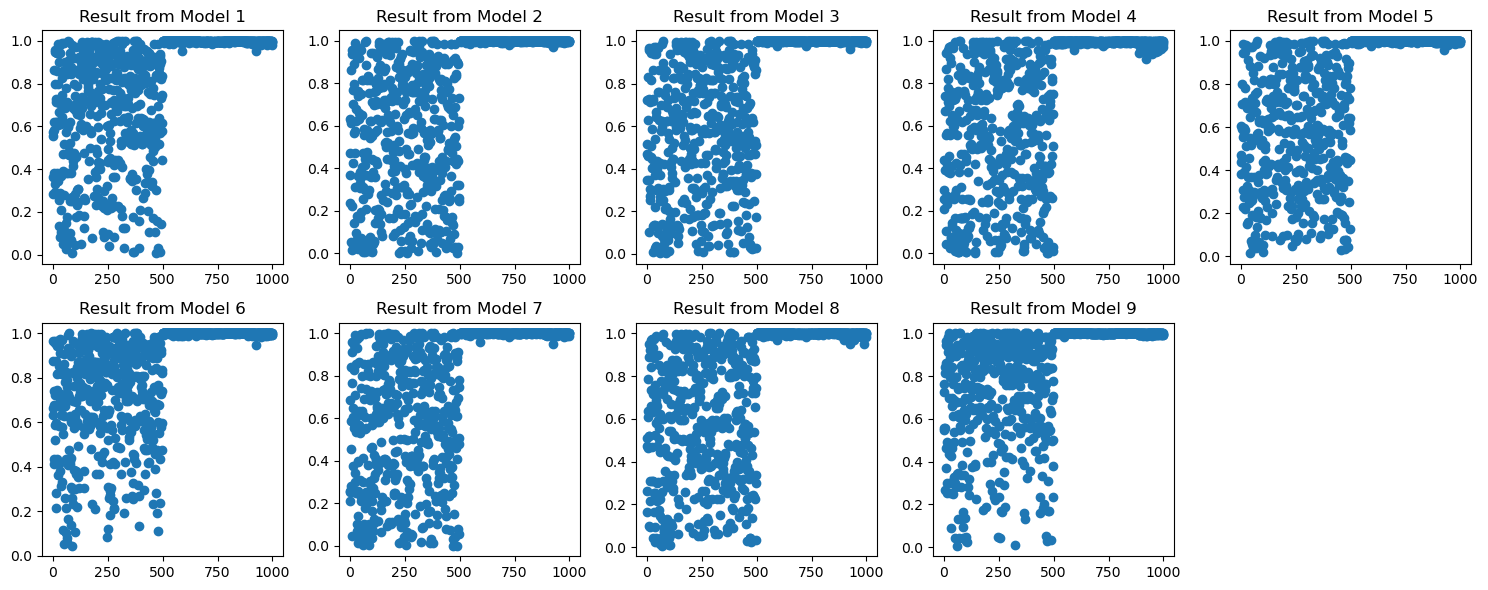

In [15]:
max_cols = 5 # for plotting purposes
max_rows = int(np.ceil(num_splits / 5)) # for plotting purposes
plt.figure(figsize=(15, max_rows * 3)) 
for i in range(num_splits):
    plt.subplot(max_rows, max_cols, i + 1) 
    plt.scatter(range(len(result_all[i])), result_all[i])
    plt.title(f"Result from Model {i+1}")
plt.tight_layout()
plt.show()

## Set threshold, evaluate performance of the ensemble

Confusion Matrix from model 1:
[[500   0]
 [ 54 446]]
Accuracy from model 1: 0.946
Precision from model 1: 1.0
Recall from model 1: 0.892
Confusion Matrix from model 2:
[[500   0]
 [ 44 456]]
Accuracy from model 2: 0.956
Precision from model 2: 1.0
Recall from model 2: 0.912
Confusion Matrix from model 3:
[[500   0]
 [ 41 459]]
Accuracy from model 3: 0.959
Precision from model 3: 1.0
Recall from model 3: 0.918
Confusion Matrix from model 4:
[[495   5]
 [ 43 457]]
Accuracy from model 4: 0.952
Precision from model 4: 0.9891774891774892
Recall from model 4: 0.914
Confusion Matrix from model 5:
[[500   0]
 [ 40 460]]
Accuracy from model 5: 0.96
Precision from model 5: 1.0
Recall from model 5: 0.92
Confusion Matrix from model 6:
[[499   1]
 [ 62 438]]
Accuracy from model 6: 0.937
Precision from model 6: 0.9977220956719818
Recall from model 6: 0.876
Confusion Matrix from model 7:
[[499   1]
 [ 48 452]]
Accuracy from model 7: 0.951
Precision from model 7: 0.9977924944812362
Recall from model 

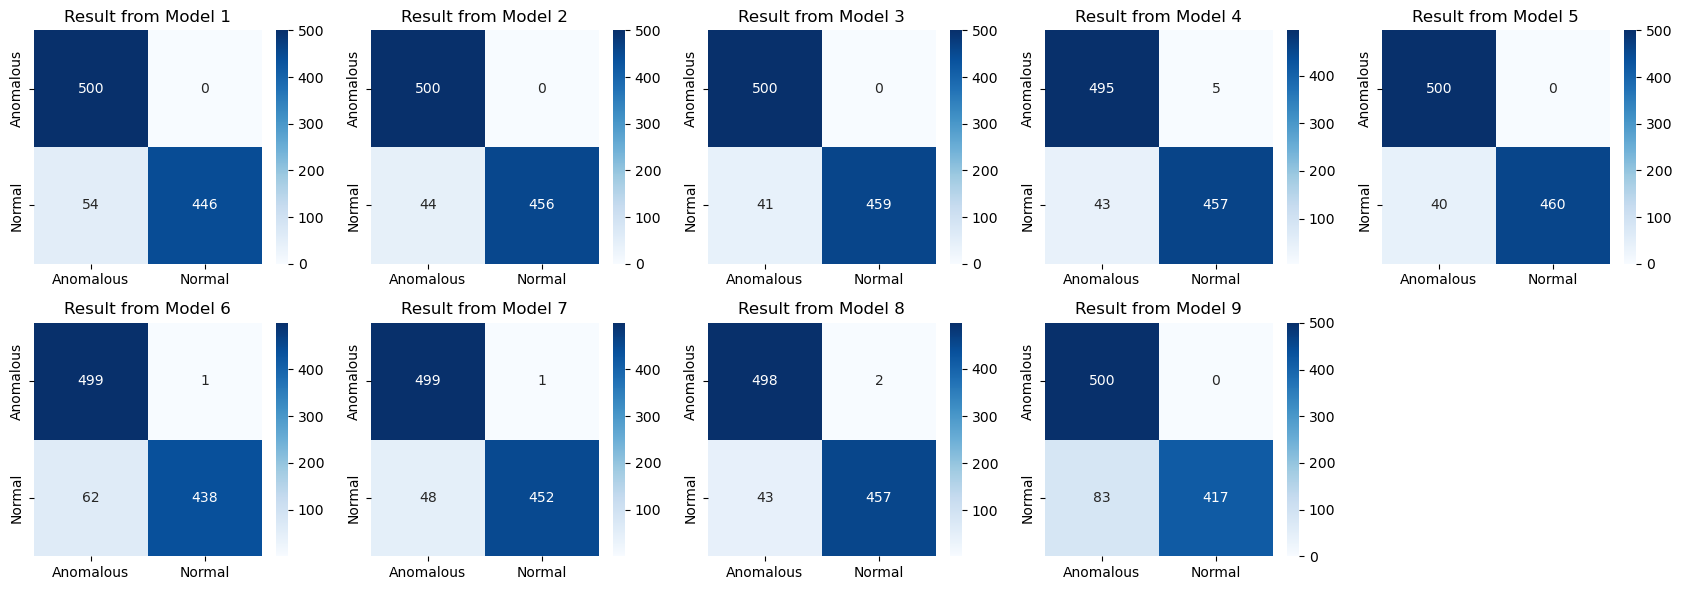

In [16]:
alpha = 0.05

selected_indices_all = []
predicted_labels_all = []
cm_all = []
accuracy_all = []
precision_all = []
recall_all = []

for i in range(num_splits):
    result_i = result_all[i]
    selected_indices_i = np.where(result_i > 1-alpha)
    selected_indices_all.append(selected_indices_i)
    selected_values_i = result_i[selected_indices_i]

    predicted_labels_i = np.ones_like(true_labels)
    predicted_labels_i[selected_indices_i] = 0
    predicted_labels_all.append(predicted_labels_i)

    cm_i = confusion_matrix(true_labels, predicted_labels_i)
    cm_all.append(cm_i)

    print(f"Confusion Matrix from model {i+1}:")
    print(cm_i)

    accuracy_i = accuracy_score(true_labels, predicted_labels_i)
    accuracy_all.append(accuracy_i)
    precision_i = precision_score(true_labels, predicted_labels_i)
    precision_all.append(precision_i)
    recall_i = recall_score(true_labels, predicted_labels_i)
    recall_all.append(recall_i)

    print(f"Accuracy from model {i+1}: {accuracy_i}")
    print(f"Precision from model {i+1}: {precision_i}")
    print(f"Recall from model {i+1}: {recall_i}")

plt.figure(figsize=(17, max_rows * 3)) 
for i in range(num_splits):
    plt.subplot(max_rows, max_cols, i + 1) 
    sns.heatmap(cm_all[i], annot=True, fmt="d", cmap="Blues", xticklabels=['Anomalous', 'Normal'], yticklabels=['Anomalous', 'Normal'])
    plt.title(f"Result from Model {i+1}")
plt.tight_layout()
plt.show()

## Merge results
The anomaly score of the ensemble is the sample average of the anomaly scores of the models.

Confusion for the ensemble:
[[500   0]
 [ 42 458]]
Accuracy for the ensemble: 0.958
Precision for the ensemble: 1.0
Recall for the ensemble: 0.916


<Axes: >

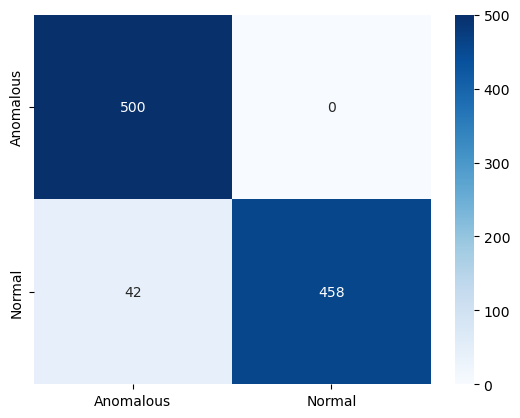

In [17]:
alpha = 0.05

result_merged = np.array([sum(x)/num_splits for x in zip(*result_all)])

selected_indices_merged = np.where(result_merged > 1-alpha)
selected_values_merged = result_i[selected_indices_merged]

predicted_labels_merged = np.ones_like(true_labels)
predicted_labels_merged[selected_indices_merged] = 0

cm_merged = confusion_matrix(true_labels, predicted_labels_merged)

print(f"Confusion for the ensemble:")
print(cm_merged)

accuracy_merged = accuracy_score(true_labels, predicted_labels_merged)
precision_merged = precision_score(true_labels, predicted_labels_merged)
recall_merged = recall_score(true_labels, predicted_labels_merged)

print(f"Accuracy for the ensemble: {accuracy_merged}")
print(f"Precision for the ensemble: {precision_merged}")
print(f"Recall for the ensemble: {recall_merged}")

sns.heatmap(cm_merged, annot=True, fmt="d", cmap="Blues", xticklabels=['Anomalous', 'Normal'], yticklabels=['Anomalous', 'Normal'])

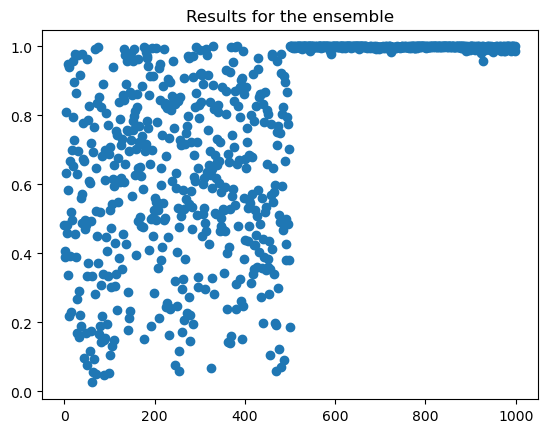

In [18]:
plt.scatter(range(len(result_merged)), result_merged)
plt.title(f"Results for the ensemble")
plt.show()